In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# NOTE: Make a shortcut to APS360 Project folder in your MyDrive
DATA_PATH = '/content/drive/MyDrive/APS360 Project/vegetable dataset'

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting

import torch.optim as optim

training_set_path = DATA_PATH + '/training'
validation_set_path = DATA_PATH + '/validation'
test_set_path = DATA_PATH + '/test'


# Transform Settings
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])
training_dataset = datasets.ImageFolder(training_set_path, transform=data_transform)
validation_dataset = datasets.ImageFolder(validation_set_path, transform=data_transform)
# test_dataset = datasets.ImageFolder(test_set_path, transform=data_transform)

print("Number of training images:", len(training_dataset))
print("Number of validation images:", len(validation_dataset))
# print("Number of test images:", len(test_dataset))

Number of training images: 2016
Number of validation images: 677


In [3]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True).cuda()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [8]:
import os
from torch.utils.data.dataloader import DataLoader
useCuda = True

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=1, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True)
# test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=1, shuffle=True)

FEATURE_PATH = '/content/drive/MyDrive/APS360 Project/alexnet_features'

classes = [
    'asparagus',
    'bell pepper',
    'broccoli',
    'cabbage',
    'carrot',
    'celery',
    'chilli pepper',
    'corn',
    'cucumber',
    'eggplant',
    'lettuce',
    'mushroom',
    'onion',
    'peas',
    'potato',
    'pumpkin',
    'raddish',
    'spinach',
    'sweet potato',
    'tomato'
]

training_feature_path = FEATURE_PATH + '/training/'
validation_feature_path = FEATURE_PATH + '/validation/'

n=0
for img, label in train_loader:
  features = alexnet.features(img.cuda())
  tensor = torch.from_numpy(features.detach().cpu().numpy())
  torch.save(tensor.squeeze(0), training_feature_path + str(classes[label.cuda()]) + '/' + str(n) + '.tensor')
  n+=1

n=0
for img, label in validation_loader:
  features = alexnet.features(img.cuda())
  tensor = torch.from_numpy(features.detach().cpu().numpy())
  torch.save(tensor.squeeze(0), validation_feature_path + str(classes[label.cuda()]) + '/' + str(n) + '.tensor')
  n+=1

# test_path = '/content/drive/MyDrive/Lab 3/Test_Set_Features/'
# n=0
# for img, label in test_loader:
#   features = alexnet.features(img)
#   tensor = torch.from_numpy(features.detach().numpy())
#   torch.save(tensor.squeeze(0), test_path + str(classes[label]) + '/' + str(n) + '.tensor')
#   n+=1


In [9]:
class AlexNetCNN(nn.Module):
    def __init__(self):
        super(AlexNetCNN, self).__init__()
        self.name = "AlexNetCNN"
        self.conv1 = nn.Conv2d(256, 256, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 1 * 1, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 256 * 1 * 1)
        x = self.fc1(x)
        return x

In [13]:
FEATURE_PATH = '/content/drive/MyDrive/APS360 Project/alexnet_features'

training_feature_path = FEATURE_PATH + '/training'
validation_feature_path = FEATURE_PATH + '/validation'


training_features = torchvision.datasets.DatasetFolder(training_feature_path, loader=torch.load, extensions=('.tensor'))

validation_features = torchvision.datasets.DatasetFolder(validation_feature_path, loader=torch.load, extensions=('.tensor'))

# test_features = torchvision.datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

In [14]:
def get_accuracy_alex(model, train_loader, valid_loader, train=False):
    use_cuda = True
    if train:
        data = train_loader
    else:
        data = valid_loader

    correct = 0
    total = 0
    for imgs, labels in data:    
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [15]:
def train_alex(model, train_dataset, valid_dataset, batch_size=64, learning_rate=0.001, num_epochs=1):
    # Prepare Dataloader
    use_cuda = True
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)     

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for features, labels in iter(train_loader):
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
            #############################################
            
            
            out = model(features)      # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch


        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy_alex(model, train_loader, valid_loader, train=True)) # compute training accuracy
        val_acc.append(get_accuracy_alex(model, train_loader, valid_loader, train=False))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} |"+"Validation acc: {}").format(epoch + 1,train_acc[-1],val_acc[-1]))
        torch.save(model.state_dict(), "saved_model")
      
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy") 
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1: Train acc: 0.08560118753092529 |Validation acc: 0.08645533141210375
Epoch 2: Train acc: 0.24542305789213262 |Validation acc: 0.2132564841498559
Epoch 3: Train acc: 0.39485403265710045 |Validation acc: 0.34293948126801155
Epoch 4: Train acc: 0.48540326571004455 |Validation acc: 0.4423631123919308
Epoch 5: Train acc: 0.5517070757050965 |Validation acc: 0.5
Epoch 6: Train acc: 0.5937654626422563 |Validation acc: 0.5302593659942363
Epoch 7: Train acc: 0.6506679861454725 |Validation acc: 0.5720461095100865
Epoch 8: Train acc: 0.6838198911429986 |Validation acc: 0.6152737752161384
Epoch 9: Train acc: 0.7199406234537358 |Validation acc: 0.6642651296829971
Epoch 10: Train acc: 0.7431964374072242 |Validation acc: 0.6844380403458213


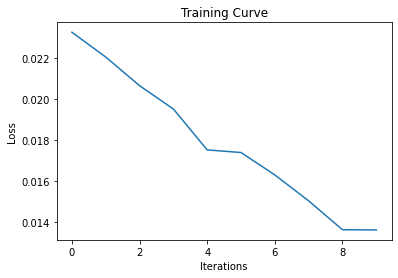

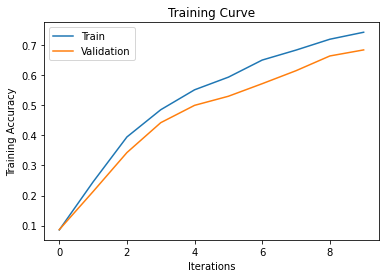

Final Training Accuracy: 0.7431964374072242
Final Validation Accuracy: 0.6844380403458213


In [16]:
best_alex_model = AlexNetCNN()

best_alex_model.cuda()

train_alex(best_alex_model, training_features, validation_features, learning_rate=0.0001, batch_size=128, num_epochs=10)